In [134]:
# Import modules

%matplotlib notebook

from tensorflow import keras
from graph_model import CallBacks, DataGenerator, GraphNet

import numpy as np
from scipy.interpolate import Rbf
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy, shapely
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import pandas as pd
import os
import pickle
import shutil

In [2]:
# Define the data directories

model_name = "max-aggregate2_dropout=0.15+Gaussian"

cwd = os.getcwd()
data_dir = os.path.join(cwd, "data")
save_dir = os.path.join(cwd, "save", model_name)
processed_waveform_dir = os.path.join(data_dir, "waveforms_proc_broadband")

savefile_best = "best-model.h5"
savefile_last = "last-model.h5"

# Data preparation

In [3]:
# Fix random seed for reproducibility
# Note: keep this seed the same as during data preparation and training!
np.random.seed(0)

# Data ranges (min/max)
minlatitude = 32
maxlatitude = 36
minlongitude = -120
maxlongitude = -116
maxdepth = 30e3
minmag = 3
maxmag = 6

# Fraction of the data to be used in training
split = 0.8

In [4]:
def scale(x):
    """ Function to scale the data in the range +/- 1 """
    if len(x.shape) == 2:
        x[:, 0] = (x[:, 0] - minlatitude) / (maxlatitude - minlatitude)
        x[:, 1] = (x[:, 1] - minlongitude) / (maxlongitude - minlongitude)
        x[:, 2] = x[:, 2] / maxdepth
        x[:, 3] = (x[:, 3] - minmag) / (maxmag - minmag)
    elif len(x.shape) == 3:
        x[:, :, 0] = (x[:, :, 0] - minlatitude) / (maxlatitude - minlatitude)
        x[:, :, 1] = (x[:, :, 1] - minlongitude) / (maxlongitude - minlongitude)
        x[:, :, 2] = x[:, :, 2] / maxdepth
        x[:, :, 3] = (x[:, :, 3] - minmag) / (maxmag - minmag)
    x = (x - 0.5) * 2
    return x


def unscale(x):
    """ Function to unscale the data """
    x = x / 2 + 0.5
    if len(x.shape) == 2:
        x[:, 0] = x[:, 0] * (maxlatitude - minlatitude) + minlatitude
        x[:, 1] = x[:, 1] * (maxlongitude - minlongitude) + minlongitude
        x[:, 2] = x[:, 2] * maxdepth * 1e-3
        x[:, 3] = x[:, 3] * (maxmag - minmag) + minmag
    elif len(x.shape) == 3:
        x[:, :, 0] = x[:, :, 0] * (maxlatitude - minlatitude) + minlatitude
        x[:, :, 1] = x[:, :, 1] * (maxlongitude - minlongitude) + minlongitude
        x[:, :, 2] = x[:, :, 2] * maxdepth * 1e-3
        x[:, :, 3] = x[:, :, 3] * (maxmag - minmag) + minmag
    return x

<IPython.core.display.Javascript object>


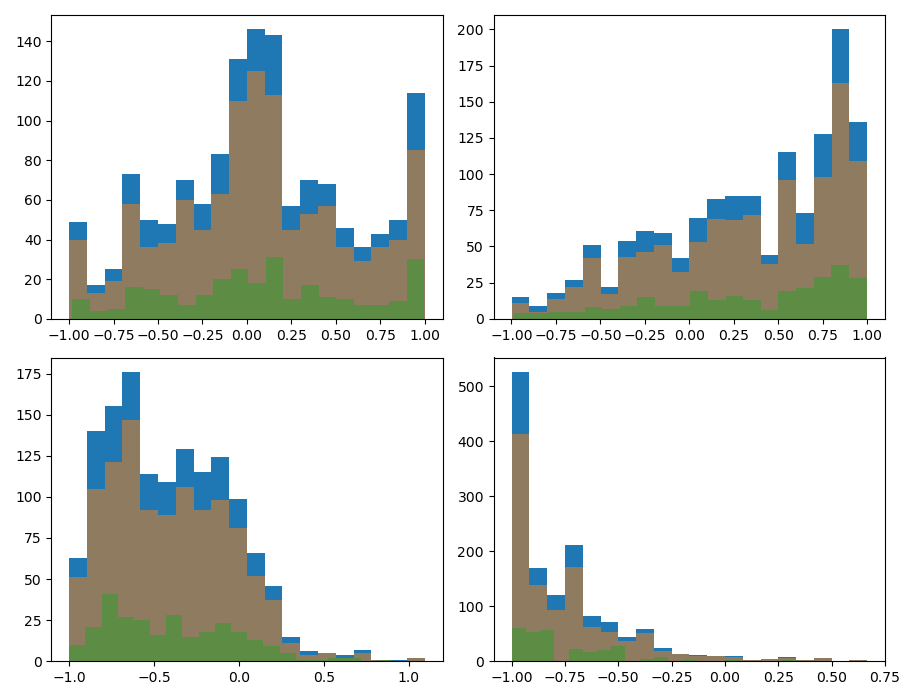

In [5]:
# Get the event catalogue
catalogue = pd.read_csv(os.path.join(data_dir, "catalogue.csv"))[["lat", "lon", "depth", "mag"]]

# Check which events have data
for i, event in catalogue.iterrows():
    # Event data file
    cat_file = os.path.join(processed_waveform_dir, "%d.npy" % i)
    # If file not exists: remove event from catalogue
    if not os.path.isfile(cat_file):
        catalogue.drop(index=i, inplace=True)

# Event identifiers
ids = catalogue.index.values
# Uniform weights
weights = np.ones((len(ids), 1))
# Event lat/lon/depth/magnitude
catalogue = catalogue.values

# Scale the catalogue data
catalogue = scale(catalogue)
# Concatenate the IDs and weights to the catalogue data
catalogue = np.concatenate([ids.reshape(-1, 1), weights.reshape(-1, 1), catalogue], axis=1)

# Split events into train and validation sets
inds = np.arange(catalogue.shape[0])
np.random.shuffle(inds)
N_split = int(split * catalogue.shape[0])

train_inds = inds[:N_split]
test_inds = inds[N_split:]

# Split catalogue
train_catalogue = catalogue[train_inds]
test_catalogue = catalogue[test_inds]

# Check data distributions to ensure that train and validation sets are similar!
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))
axes = axes.ravel()

for i in range(4):
    ax = axes[i]
    ax.hist(catalogue[:, i+2], bins=20, density=False)
    ax.hist(train_catalogue[:, i+2], bins=20, alpha=0.5, density=False)
    ax.hist(test_catalogue[:, i+2], bins=20, alpha=0.5, density=False)

plt.tight_layout()    
plt.show()

In [6]:
# Read seismic station information
stations = pd.read_csv(os.path.join(data_dir, "stations.csv"))[["code", "lat", "lon"]]
# Scale station geographic locations
stations["lat"] = ((stations["lat"] - minlatitude) / (maxlatitude - minlatitude) - 0.5) * 2
stations["lon"] = ((stations["lon"] - minlongitude) / (maxlongitude - minlongitude) - 0.5) * 2

In [7]:
# Open the event-station lookup file
lookup_file = os.path.join(data_dir, "catalogue_station_lookup_final.pickle")

with open(lookup_file, "rb") as f:
    lookup = pickle.load(f)

# Load model

In [133]:
# Reload the best model state
last_file = os.path.join(save_dir, savefile_best)
model = keras.models.load_model(last_file)

[autoreload of tensorflow.python.keras.layers.core failed: Traceback (most recent call last):
  File "/u/moana/user/vanden/miniconda3/envs/TensorFlow/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/u/moana/user/vanden/miniconda3/envs/TensorFlow/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/u/moana/user/vanden/miniconda3/envs/TensorFlow/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/u/moana/user/vanden/miniconda3/envs/TensorFlow/lib/python3.7/importlib/__init__.py", line 148, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module graph_model not in sys.modules
]


In [9]:
# Number of stations per sample
N_sub = 50
# Number of time sample points
N_t = 2048

# Instantiate data generator
eval_generator = DataGenerator(
    data_dir=processed_waveform_dir,
    catalogue=catalogue,
    stations=stations,
    lookup=lookup,
    N_sub=N_sub,
    N_t=N_t,
    batch_size=32,
)

[autoreload of tensorflow.python.keras.layers.core failed: Traceback (most recent call last):
  File "/u/moana/user/vanden/miniconda3/envs/TensorFlow/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/u/moana/user/vanden/miniconda3/envs/TensorFlow/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/u/moana/user/vanden/miniconda3/envs/TensorFlow/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/u/moana/user/vanden/miniconda3/envs/TensorFlow/lib/python3.7/importlib/__init__.py", line 148, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module graph_model not in sys.modules
]


# Reference results

Since the model enables dropout at inference time, the model predictions for the seismic source characteristics are probabilistic. By evaluating a single input sample multiple times, we get an approximate posterior distribution from which we can estimate model uncertainties and confidence intervals.

In [110]:
# Number of evaluations per sample
N_eval = 100

# Extract quantities from the data generator
waveforms = eval_generator.waveforms
coords = eval_generator.station_coords
weights = eval_generator.weights
labels = eval_generator.labels

# Buffer for the posterior samples
all_results = np.zeros((N_eval, len(labels), 4))

# Perform inference N_eval times
for i in range(N_eval):
    print(i)
    # Store predictions in buffer
    all_results[i] = model.predict((waveforms, coords, weights))

# Get the mean and standard deviation of the model posterior
results = np.mean(all_results, axis=0)
results_std = np.std(all_results, axis=0)

# Scale the results back to physical units
scaled_results = unscale(results)
scaled_all_results = unscale(all_results)
scaled_results_std = np.std(scaled_all_results, axis=0)
scaled_labels = unscale(labels)
tiled_labels = np.tile(scaled_labels, [N_eval, 1, 1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Compute prediction accuracy and precision from the model posterior. Then, save the results to a NumPy file:

In [111]:
# Conversion factor from degrees to kilometres
latlon_km = 40075 / 360.

# Compute the errors in the predictions
err_dist = np.sqrt((scaled_all_results[:, :, 0] - tiled_labels[:, :, 0])**2 + (scaled_all_results[:, :, 1] - tiled_labels[:, :, 1])**2) * latlon_km
err_lat = np.abs(scaled_all_results[:, :, 0] - tiled_labels[:, :, 0])
err_lon = np.abs(scaled_all_results[:, :, 1] - tiled_labels[:, :, 1])
err_depth = np.abs(scaled_all_results[:, :, 2] - tiled_labels[:, :, 2])
err_mag = np.abs(scaled_all_results[:, :, 3] - tiled_labels[:, :, 3])
err_all = np.abs(scaled_all_results - tiled_labels)

# Report prediction errors and precision
print("Location error: %.2f +/- %.2f km" % (err_dist.mean(), err_dist.std()))
print("Depth error: %.2f +/- %.2f km" % (err_depth.mean(), err_depth.std()))
print("Magnitude error: %.2f +/- %.2f" % (err_mag.mean(), err_mag.std()))

# Save posterior to a NumPy file
outfile = "results_ref.npy"
np.save(outfile, scaled_all_results)

Location error: 18.29 +/- 18.52 km
Depth error: 3.27 +/- 2.87 km
Magnitude error: 0.13 +/- 0.16


(1377, 4)


<IPython.core.display.Javascript object>


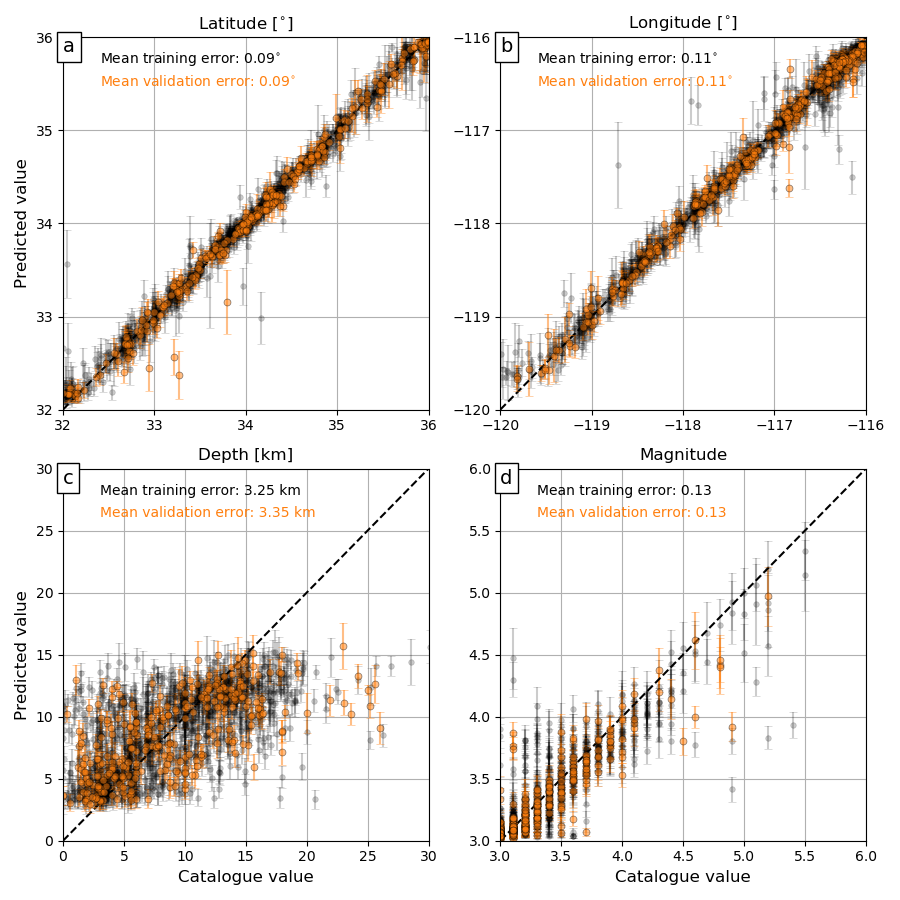

In [112]:
""" Plot results: Supplementary Figure S1 """


# Reload the posterior of the reference model
results_ref = np.load("results_ref.npy")

# Get the mean and standard deviation of the model posterior
scaled_results = np.mean(results_ref, axis=0)
results_std = np.std(results_ref, axis=0)

# Prepare a 2x2 figure canvas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
axes = axes.ravel()

# Define titles, panel letters, etc.
titles = (r"Latitude [$^{\circ}$]", r"Longitude [$^{\circ}$]", "Depth [km]", "Magnitude")
ticks = (
    np.linspace(minlatitude, maxlatitude, 5),
    np.linspace(minlongitude, maxlongitude, 5),
    np.linspace(0, maxdepth * 1e-3, 7),
    np.linspace(minmag, maxmag, 7),
)
ranges = ((minlatitude, maxlatitude), (minlongitude, maxlongitude), (0, maxdepth * 1e-3), (minmag, maxmag))
units = (r"$^{\circ}$", r"$^{\circ}$", " km", "")
letters = "abcd"

# Loop over lat/lon/depth/magnitude quantities
for i in range(4):
    ax = axes[i]
    # Set title
    ax.set_title(titles[i])
    # Write panel letter
    ax.text(
        x=0.0, y=1, transform=ax.transAxes, s=letters[i], fontsize=14, 
        verticalalignment="top", bbox={"edgecolor": "k", "linewidth": 1, "facecolor": "w",}
    )
    # Plot 1:1 line
    ax.plot(ranges[i], ranges[i], "k--")
    # Plot data
    ax.errorbar(
        scaled_labels[train_inds, i], scaled_results[train_inds, i], yerr=results_std[train_inds, i], 
        fmt="o", ms=4, alpha=0.2, mfc="k", ecolor="k", mec="k", mew=0.5, capsize=3,
    )
    ax.errorbar(
        scaled_labels[test_inds, i], scaled_results[test_inds, i], yerr=results_std[test_inds, i], 
        fmt="o", ms=5, alpha=0.5, mfc="C1", ecolor="C1", mec="k", mew=0.5, capsize=3,
    )
    # Add error estimates
    ax.text(
        x=0.1, y=0.93, transform=ax.transAxes, c="k",
        s=r"Mean training error: %.2f%s" % (err_all[:, train_inds, i].mean(), units[i])
    )
    ax.text(
        x=0.1, y=0.87, transform=ax.transAxes, c="C1",
        s=r"Mean validation error: %.2f%s" % (err_all[:, test_inds, i].mean(), units[i])
    )
    
    # Format axes
    if i // 2 == 1:
        ax.set_xlabel("Catalogue value", fontsize=12)
    if i % 2 == 0:
        ax.set_ylabel("Predicted value", fontsize=12)
    ax.set_xlim(ranges[i])
    ax.set_ylim(ranges[i])
    ax.set_xticks(ticks[i])
    ax.set_yticks(ticks[i])
    ax.grid(b=True)

plt.tight_layout()
plt.savefig("figures/fig_S1.pdf")
plt.show()

# No locations

To test the importance of the stations' geographic information, we repeat the exercise above while setting the station coordinates to zero (corresponding to a location at the centre of the domain). If the station locations are informative and used in the predictions, then the results should deteriorate.

In [113]:
# Number of evaluations per sample
N_eval = 100

# Extract quantities from the data generator
waveforms = eval_generator.waveforms
weights = eval_generator.weights
labels = eval_generator.labels
# Set station coordinates to zero (centre of domain)
coords = eval_generator.station_coords * 0

# Buffer for the posterior samples
all_results = np.zeros((N_eval, len(labels), 4))

# Perform inference N_eval times
for i in range(N_eval):
    print(i)
    # Store predictions in buffer
    all_results[i] = model.predict((waveforms, coords, weights))

# Get the mean and standard deviation of the model posterior
results = np.mean(all_results, axis=0)
results_std = np.std(all_results, axis=0)

# Scale the results back to physical units
scaled_results = unscale(results)
scaled_all_results = unscale(all_results)
scaled_results_std = np.std(scaled_all_results, axis=0)
scaled_labels = unscale(labels)
tiled_labels = np.tile(scaled_labels, [N_eval, 1, 1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [114]:
# Conversion factor from degrees to kilometres
latlon_km = 40075 / 360.

# Compute the errors in the predictions
err_dist = np.sqrt((scaled_all_results[:, :, 0] - tiled_labels[:, :, 0])**2 + (scaled_all_results[:, :, 1] - tiled_labels[:, :, 1])**2) * latlon_km
err_lat = np.abs(scaled_all_results[:, :, 0] - tiled_labels[:, :, 0])
err_lon = np.abs(scaled_all_results[:, :, 1] - tiled_labels[:, :, 1])
err_depth = np.abs(scaled_all_results[:, :, 2] - tiled_labels[:, :, 2])
err_mag = np.abs(scaled_all_results[:, :, 3] - tiled_labels[:, :, 3])
err_all = np.abs(scaled_all_results - tiled_labels)

# Report prediction errors and precision
print("Location error: %.2f +/- %.2f km" % (err_dist.mean(), err_dist.std()))
print("Depth error: %.2f +/- %.2f km" % (err_depth.mean(), err_depth.std()))
print("Magnitude error: %.2f +/- %.2f" % (err_mag.mean(), err_mag.std()))

# Save posterior to a NumPy file
outfile = "results_no-loc.npy"
np.save(outfile, scaled_all_results)

Location error: 155.37 +/- 66.48 km
Depth error: 4.30 +/- 3.15 km
Magnitude error: 0.17 +/- 0.19


(1377, 4)


<IPython.core.display.Javascript object>


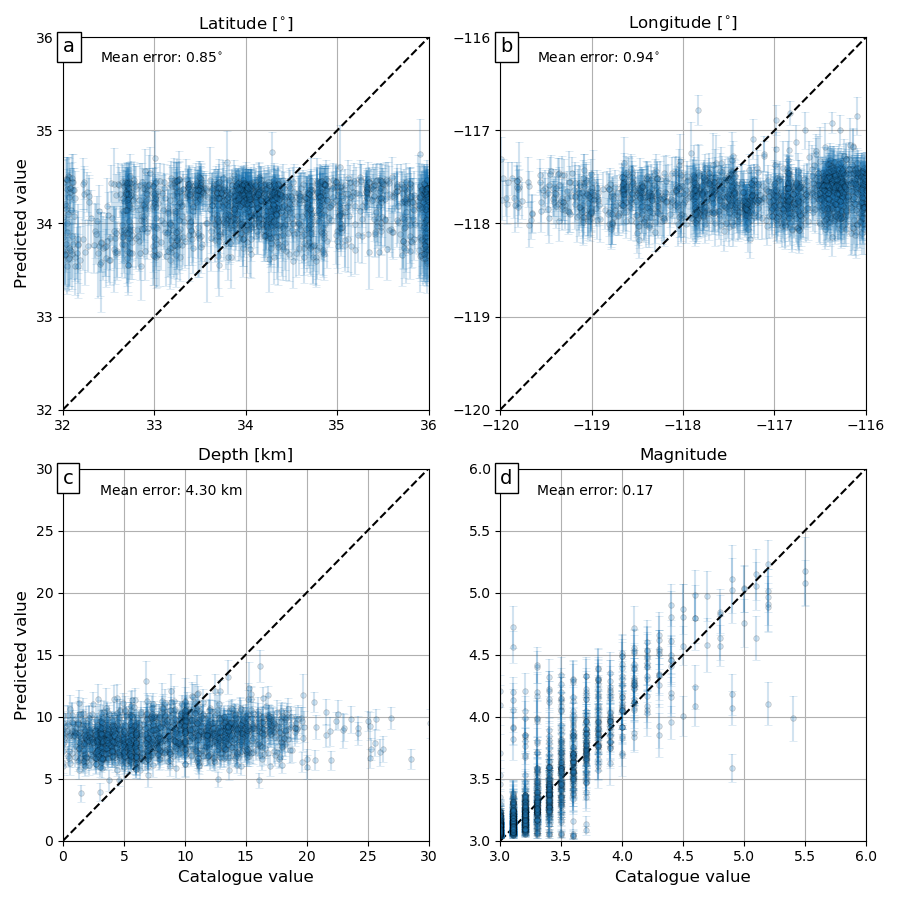

In [115]:
""" Plot results: Supplementary Figure S2 """


# Reload the posterior of the model with no geographic information
results_noloc = np.load("results_no-loc.npy")
scaled_results = np.mean(results_noloc, axis=0)
results_std = np.std(results_noloc, axis=0)

# Get the mean and standard deviation of the model posterior
scaled_results = np.mean(results_ref, axis=0)
results_std = np.std(results_ref, axis=0)

# Prepare a 2x2 figure canvas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
axes = axes.ravel()

# Define titles, panel letters, etc.
titles = (r"Latitude [$^{\circ}$]", r"Longitude [$^{\circ}$]", "Depth [km]", "Magnitude")
ticks = (
    np.linspace(minlatitude, maxlatitude, 5),
    np.linspace(minlongitude, maxlongitude, 5),
    np.linspace(0, maxdepth * 1e-3, 7),
    np.linspace(minmag, maxmag, 7),
)
ranges = ((minlatitude, maxlatitude), (minlongitude, maxlongitude), (0, maxdepth * 1e-3), (minmag, maxmag))
units = (r"$^{\circ}$", r"$^{\circ}$", " km", "")
letters = "abcd"

# Loop over lat/lon/depth/magnitude quantities
for i in range(4):
    ax = axes[i]
    # Set title
    ax.set_title(titles[i])
    # Write panel letter
    ax.text(
        x=0.0, y=1, transform=ax.transAxes, s=letters[i], fontsize=14, 
        verticalalignment="top", bbox={"edgecolor": "k", "linewidth": 1, "facecolor": "w",}
    )
    # Plot 1:1 line
    ax.plot(ranges[i], ranges[i], "k--")
    # Plot data
    ax.errorbar(
        scaled_labels[:, i], scaled_results[:, i], yerr=results_std[:, i], 
        fmt="o", ms=4, alpha=0.2, mfc="C0", ecolor="C0", mec="k", mew=0.5, capsize=3,
    )

    # Add error estimates
    ax.text(
        x=0.1, y=0.93, transform=ax.transAxes, c="k",
        s=r"Mean error: %.2f%s" % (err_all[:, :, i].mean(), units[i])
    )
    
    # Format axes
    if i // 2 == 1:
        ax.set_xlabel("Catalogue value", fontsize=12)
    if i % 2 == 0:
        ax.set_ylabel("Predicted value", fontsize=12)
    ax.set_xlim(ranges[i])
    ax.set_ylim(ranges[i])
    ax.set_xticks(ticks[i])
    ax.set_yticks(ticks[i])
    ax.grid(b=True)

plt.tight_layout()
plt.savefig("figures/fig_S1.pdf")
plt.show()

# Combined distributions

The cell below generates Figure 2 in the manuscript, which includes the error distributions for the reference model and the model with no station location

<IPython.core.display.Javascript object>


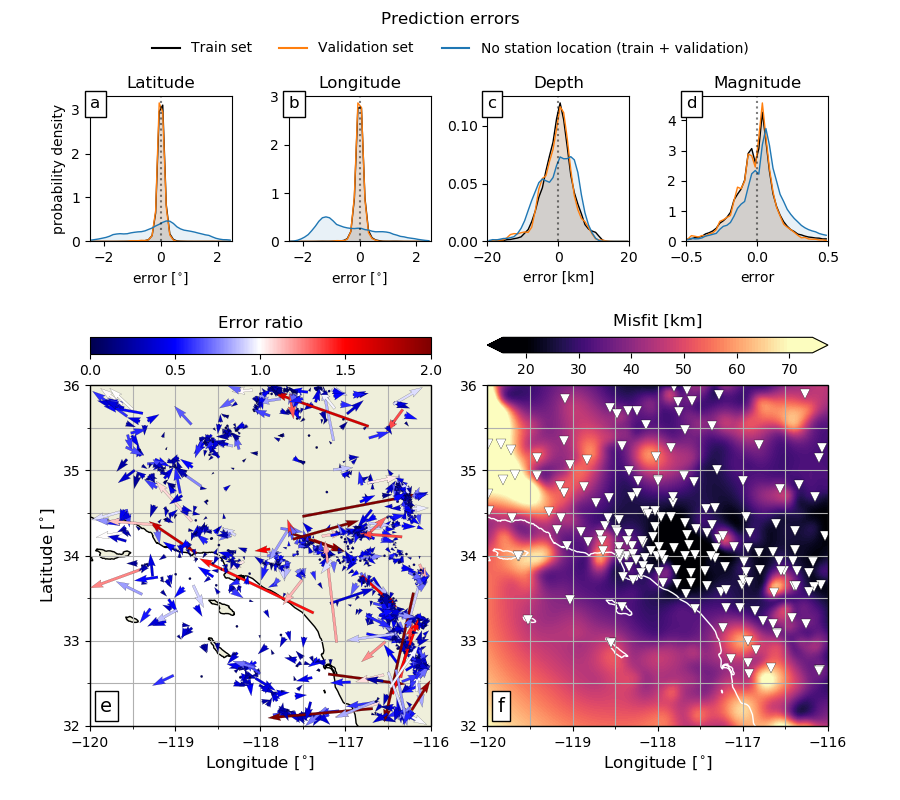

In [116]:
latlon_km = 40075 / 360.
N_eval = 100
labels = eval_generator.labels
scaled_labels = unscale(labels)
tiled_labels = np.tile(scaled_labels, [N_eval, 1, 1])

# Load model posteriors
results_ref = np.load("results_ref.npy")
results_noloc = np.load("results_no-loc.npy")

# Draw figure canvas
fig = plt.figure(figsize=(9, 8))
spec = gridspec.GridSpec(nrows=3, ncols=4, figure=fig)
axes = [
    fig.add_subplot(spec[0, 0]), fig.add_subplot(spec[0, 1]), fig.add_subplot(spec[0, 2]), 
    fig.add_subplot(spec[0, 3]), fig.add_subplot(spec[1:, :2], projection=ccrs.PlateCarree()), 
    fig.add_subplot(spec[1:, 2:], projection=ccrs.PlateCarree())
]

# Subplot headings
titles = (r"Latitude", r"Longitude", "Depth", "Magnitude")
# 
ranges = ((minlatitude, maxlatitude), (minlongitude, maxlongitude), (0, maxdepth * 1e-3), (minmag, maxmag))
err_ranges = ((-2.5, 2.5), (-2.5, 2.5), (-20, 20), (-0.5, 0.5))
units = (r"$^{\circ}$", r"$^{\circ}$", " km", "")
letters = "abcdefghij"

"""
Panels (a)-(d): Probability density distributions of the model prediction errors
"""
for i in range(4):
    ax = axes[i]
    # Set title
    ax.set_title(titles[i])
    # Write panel letter
    ax.text(
        x=0.0, y=1, transform=ax.transAxes, s=letters[i], fontsize=12, 
        verticalalignment="top", bbox={"edgecolor": "k", "linewidth": 1, "facecolor": "w",}
    )
    
    # Errors on the training set
    train_diff = (results_ref[:, train_inds, i] - tiled_labels[:, train_inds, i]).ravel()
    train_hist, train_bins = np.histogram(train_diff, bins=40, range=err_ranges[i], density=True)
    train_bins = 0.5 * (train_bins[1:] + train_bins[:-1])
    
    ax.plot(train_bins, train_hist, c="k", lw=1., alpha=1)
    ax.fill_between(train_bins, 0, train_hist, fc="k", alpha=0.1)
    
    # Errors on the test set
    test_diff = (results_ref[:, test_inds, i] - tiled_labels[:, test_inds, i]).ravel()
    test_hist, test_bins = np.histogram(test_diff, bins=40, range=err_ranges[i], density=True)
    test_bins = 0.5 * (test_bins[1:] + test_bins[:-1])
    
    ax.plot(test_bins, test_hist, c="C1", lw=1., alpha=1)
    ax.fill_between(test_bins, 0, test_hist, fc="C1", alpha=0.1)
    
    # Errors on the full data when no locations are provided
    diff = (results_noloc[:, :, i] - tiled_labels[:, :, i]).ravel()
    hist, bins = np.histogram(diff, bins=40, range=err_ranges[i], density=True)
    bins = 0.5 * (bins[1:] + bins[:-1])
    
    ax.plot(bins, hist, c="C0", lw=1., alpha=1)
    ax.fill_between(bins, 0, hist, fc="C0", alpha=0.1)
    
    # Plot x=0 line for reference
    ax.axvline(0, ls=":", c="k", alpha=0.5)
    
    # Format axes
    ax.set_ylim(ymin=0)
    ax.set_xlim(err_ranges[i])
    if len(units[i]) > 0:
        ax.set_xlabel(r"error [%s]" % units[i].strip())
    else:
        ax.set_xlabel("error")
    if i == 0:
        ax.set_ylabel("probability density")


"""
Compute errors on the epicentre locations, and spatially interpolate using radial basis functions
"""

# Epicentre location errors
lats = np.mean(results_ref[:, :, 0], axis=0)
lats_err = np.std(results_ref[:, :, 0], axis=0)
lats_diff = scaled_labels[:, 0] - lats
lons = np.mean(results_ref[:, :, 1], axis=0)
lons_err = np.std(results_ref[:, :, 1], axis=0)
lons_diff = scaled_labels[:, 1] - lons
err_radius = 2 * np.sqrt(lons_err**2 + lats_err**2)
err_radius_m = 2 * np.sqrt(lons_err**2 + lats_err**2) * latlon_km * 1e3
err_ratio = np.sqrt(lats_diff**2 + lons_diff**2) / err_radius

# Interpolation of the error density
rbfi = Rbf(scaled_labels[:, 1], scaled_labels[:, 0], err_radius_m * 1e-3, smooth=0.5)
xi = np.linspace(minlongitude, maxlongitude, 100)
yi = np.linspace(minlatitude, maxlatitude, 100)
Xi, Yi = np.meshgrid(xi, yi)
error_density = rbfi(Xi, Yi)

# Station geographic locations
station_lats = (0.5 * stations["lat"].values + 0.5) * (maxlatitude - minlatitude) + minlatitude
station_lons = (0.5 * stations["lon"].values + 0.5) * (maxlongitude - minlongitude) + minlongitude

# Define grid major/minor ticks
xlocs = np.linspace(minlongitude, maxlongitude, 5)
ylocs = np.linspace(minlatitude, maxlatitude, 5)

xlocs_minor = np.linspace(minlongitude, maxlongitude, 9)
ylocs_minor = np.linspace(minlatitude, maxlatitude, 9)

# Draw land contours
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor=cfeature.COLORS['land'])


"""
Panel (e): Quiver of location errors
"""

ax = axes[4]
ax.add_feature(land_50m)
ax.coastlines(resolution="10m")
ax.set_xlabel(r"Longitude [$^{\circ}$]", fontsize=12)
ax.set_ylabel(r"Latitude [$^{\circ}$]", fontsize=12)

# Write panel letter
ax.text(
    x=0.03, y=0.03, transform=ax.transAxes, s=letters[4], fontsize=14, 
    verticalalignment="bottom", bbox={"edgecolor": "k", "linewidth": 1, "facecolor": "w",}
)

# Plot arrows pointing from the predicted epicentre to the catalogued epicentre
qv = ax.quiver(
    lons, lats, lons_diff, lats_diff, err_ratio, cmap="seismic", clim=(0, 2), width=0.03,
    units="xy", angles="xy", scale_units="xy", scale=1, linewidth=0.1, edgecolor="k", zorder=999
)

# Format axes
ax.set_extent((minlongitude, maxlongitude, minlatitude, maxlatitude))
ax.set_xticks(xlocs)
ax.set_yticks(ylocs)
ax.set_xticks(xlocs_minor, minor=True)
ax.set_yticks(ylocs_minor, minor=True)
ax.grid(b=True, which="major")
ax.grid(b=True, which="minor")


"""
Panel (f): Density map of location errors
"""

ax = axes[5]
ax.coastlines(resolution="10m", color="white")
ax.set_xlabel(r"Longitude [$^{\circ}$]", fontsize=12)

# Write panel letter
ax.text(
    x=0.03, y=0.03, transform=ax.transAxes, s=letters[5], fontsize=14, 
    verticalalignment="bottom", bbox={"edgecolor": "k", "linewidth": 1, "facecolor": "w",}
)

# Filled contours of the interpolated error density
cf = ax.contourf(
    Xi, Yi, np.clip(error_density, 15, 75), cmap="magma", vmin=20, vmax=70, levels=100, extend="both"
)
# Add contours underneath to fix the matplotlib rendering glitch
ax.contour(
    Xi, Yi, np.clip(error_density, 15, 75), cmap="magma", vmin=20, vmax=70, levels=100, zorder=-1
)
# Add seismic stations
ax.plot(station_lons, station_lats, "v", ms=7, c="w", mec="k", mew=0.2)

# Format axes
ax.set_extent((minlongitude, maxlongitude, minlatitude, maxlatitude))
ax.set_xticks(xlocs, minor=False)
ax.set_yticks(ylocs, minor=False)
ax.set_xticks(xlocs_minor, minor=True)
ax.set_yticks(ylocs_minor, minor=True)
ax.grid(b=True, which="major")
ax.grid(b=True, which="minor")


"""
Additional formatting
"""

# Adjust subplot spacings
plt.subplots_adjust(left=0.1, bottom=0.08, right=0.92, top=0.88, wspace=0.4, hspace=0.7)

# Adjust position of panel (e) to accommodate colourbar
pos4 = axes[4].get_position()
points4 = pos4.get_points()
points4[0, 1] = points4[0, 1] - 0.02
points4[1, 1] = points4[1, 1] - 0.02
pos4.set_points(points4)
axes[4].set_position(pos4)

# Add colourbar axis
cax = fig.add_axes([points4[0,0], points4[1,1] + 0.01, points4[1,0] - points4[0,0], 0.05])
cax.axis("off")
# Add colourbar
cbar1 = fig.colorbar(qv, ax=cax, ticks=[0, 0.5, 1, 1.5, 2], orientation="horizontal", fraction=1)
cbar1.set_label("Error ratio", labelpad=-45, fontsize=12)

# Adjust position of panel (f) to accommodate colourbar
pos5 = axes[5].get_position()
points5 = pos5.get_points()
points5[0, 1] = points5[0, 1] - 0.02
points5[1, 1] = points5[1, 1] - 0.02
pos5.set_points(points5)
axes[5].set_position(pos5)

# Add colourbar axis
cax = fig.add_axes([points5[0,0], points5[1,1] + 0.01, points5[1,0] - points5[0,0], 0.05])
cax.axis("off")
# Add colourbar
cbar2 = fig.colorbar(cf, ax=cax, extend="both", ticks=np.arange(20, 71, 10), orientation="horizontal", fraction=1)
cbar2.set_label("Misfit [km]", labelpad=-45, fontsize=12)
    
# Plot empty data sets for legend labels
axes[0].plot([], [], "k-", label="Train set")
axes[0].plot([], [], "C1-", label="Validation set")
axes[0].plot([], [], "C0-", label="No station location (train + validation)")

# Get handles and labels for legend
handles, lbls = axes[0].get_legend_handles_labels()
# Add legend at the top of the figure
lgd = fig.legend(
    handles, lbls, loc="upper center", ncol=3, title="Prediction errors", frameon=False, title_fontsize=12,
    labelspacing=1
)

# Save figure
plt.savefig("figures/model_performance_both.pdf")
plt.show()